## Barotropic streamfunction
Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

Set `ekey` below to plot different experiments.

In [38]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['square', 'sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg-iaf', '025deg-ryf', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
# model data paths:

# WARNING: defines a bunch of variables, including
# model, expt, exptdir, desc, filesPerYear
# locals().update(exptdata.exptdict['01deg'])

# TODO: loop over exptdata.exptdict.keys() to generate all plots

#ekey = '01deg'  # can be anything in exptdata.exptdict.keys()
# ekey = '025deg'  # can be anything in exptdata.exptdict.keys()
ekey = '1deg'  # can be anything in exptdata.exptdict.keys()

expt = exptdata.exptdict[ekey]['expt']
exptdir = exptdata.exptdict[ekey]['exptdir']
desc = exptdata.exptdict[ekey]['desc']
model = exptdata.exptdict[ekey]['model']

# BUG: these values may be incorrect
# TODO: avoid this approach - just specify a date range
if model=='access-om2':
    filesPerYear = 1
elif model=='access-om2-025':
    filesPerYear = 4
elif model=='access-om2-01':
    filesPerYear = 12

# length of climatology (may be corrected below):
n_years = 10

dataFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_month.nc'))
dataFileList.sort()

# update n_years to avoid exceeding available data
total_years = len(dataFileList)/filesPerYear  # NB: typically not an integer
n_years = min(n_years, int(total_years) )
n_files = n_years*filesPerYear


#firstfile = int(total_years-n_years)*filesPerYear  # start of calendar year
#dataFileListClim = dataFileList[firstfile:firstfile+n_files]
# dataFileListClim = dataFileList[165:285]  # to compare with https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

In [11]:
# get model grid data:
geolon_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolon_t',n=1).mean('time')
geolat_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolat_t',n=1).mean('time')

In [50]:
def get_gyre_psi(expt,n_files):
    cntrl_tx_trans = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',n=-n_files).mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts
    
    return gyre_psi

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


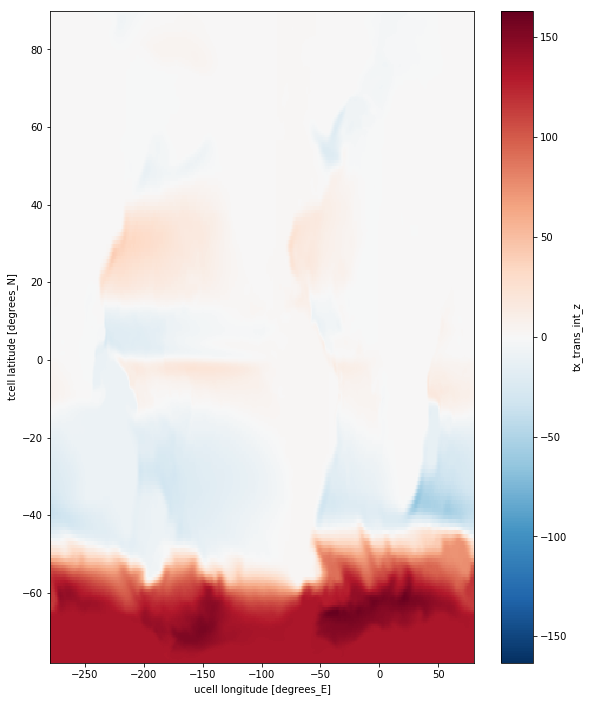

In [51]:
gyre_psi = get_gyre_psi(expt,n_files)
gyre_psi.plot()

In [55]:
def global_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-160,160.01,2)
    clev2 = np.arange(-140,140.01,10)
    
    map = Basemap(projection='mbtfpq',lon_0 = -100,resolution='l')
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-60.,61.,30.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(-180.,181.,90.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.curl, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

## Plot gyre transport, with DP transport subtracted

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


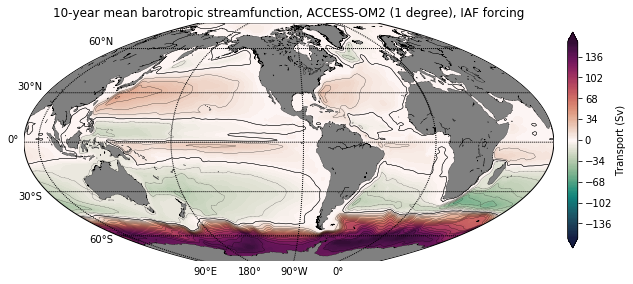

In [56]:
plt.figure(figsize(9.5,12))
plt.subplot(1,1,1)
p1 =global_map_psi(gyre_psi,geolon_t,geolat_t)

plt.title(str(n_years)+'-year mean barotropic streamfunction, ' + desc)

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('gyre_transport_'+ekey)

0 1deg_jra55v13_iaf_spinup1_A 1


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1 025deg_jra55v13_iaf 5


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2 025deg_jra55v13_ryf8485_KDS50 5


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


3 01deg_jra55v13_ryf8485_spinup6 24


/home/157/amh157/cosima-cookbook/cosima_cookbook/netcdf_index.py:391: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


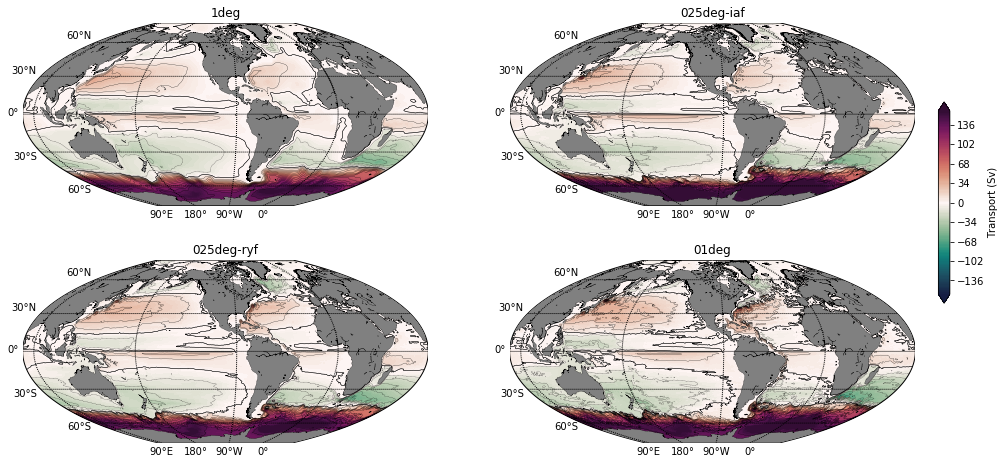

In [61]:
plt.figure(figsize(16,8))
n_files = [1, 5, 5, 24]

for i, ekey in enumerate(exptdata.exptdict.keys()):
    plt.subplot(2,2,i+1)
    expt = exptdata.exptdict[ekey]['expt']
    print(i, expt, n_files[i])
    gyre_psi = get_gyre_psi(expt,n_files[i])
    geolon_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolon_t',n=1).mean('time')
    geolat_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolat_t',n=1).mean('time')
    p1 =global_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(ekey)

ax3 = plt.axes([0.92,0.38,0.01,0.35])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('global_barotropic_streamfunctions')

## Plot ACC transport

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


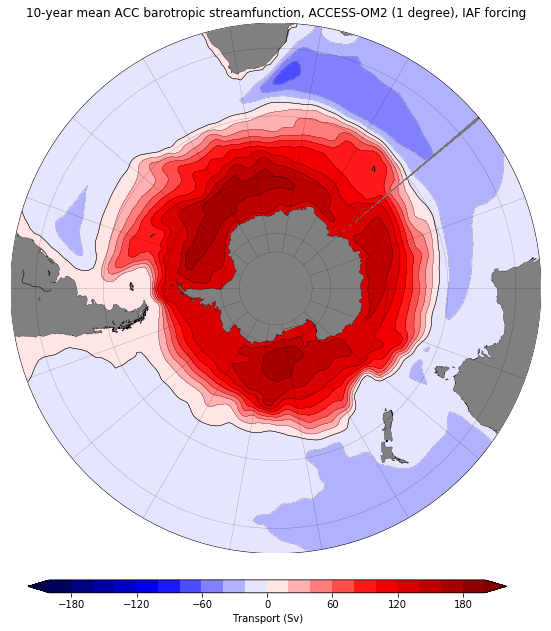

In [44]:
levels = np.linspace(-200,200,21)

plt.figure(figsize(9.5,12))

plt.subplot(1,1,1)
# map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map = Basemap(projection ='spstere',boundinglat=-25,lon_0=-150,resolution='l',round=True)
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-90.,91.,15.),linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[0,0,0,0],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=levels, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(-200,200,20)
# print clev3
map.contour(X,Y,gyre_psi,levels=clev3,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title(str(n_years)+'-year mean ACC barotropic streamfunction, ' + desc)

ax3 = plt.axes([0.15,0.15,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')

savefigure('ACC_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 9:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f9.jpeg)

## Plot Kuroshio transport, with DP transport subtracted

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3634: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analy

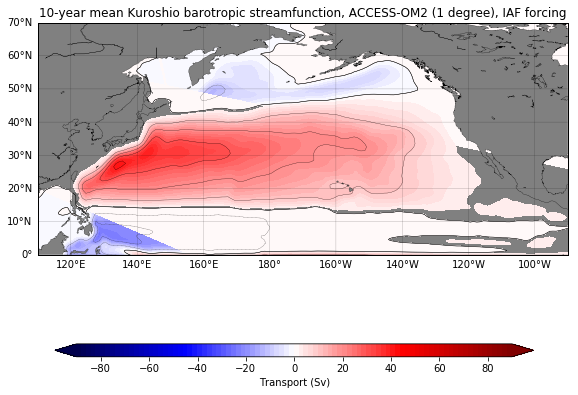

In [48]:
# gyre_psi = -cntrl_psi+cntrl_dp_ts

plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
clev = np.arange(-90,90.1,2)
clev2 = np.arange(-90,90.1,10)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=70,\
            llcrnrlon=-250,urcrnrlon=-90,resolution='l') # WARNING: includes tripole region north of 65N
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.PiYG, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title(str(n_years)+'-year mean Kuroshio barotropic streamfunction, ' + desc)

ax3 = plt.axes([0.15,0.25,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')
savefigure('Kuroshio_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 7:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f7.jpeg)

## Plot Gulf Stream transport, with DP transport subtracted

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3634: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3634: RuntimeWarning: invalid value encountered in less_equal
  condition = (xx >= self.xmin) & (xx <= self.xmax)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3647: RuntimeWarning: invalid value encountered in greater
  xx = ma.masked_where(x > 1.e20, x)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py

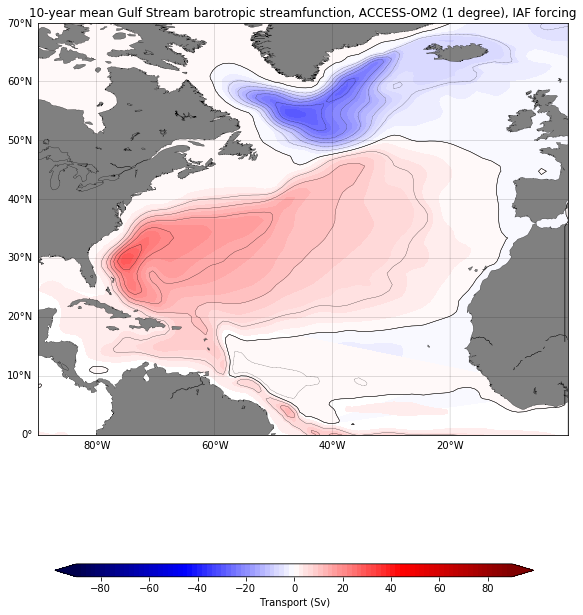

In [47]:
# gyre_psi = -cntrl_psi+cntrl_dp_ts

plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
clev = np.arange(-90,90.1,2)
clev2 = np.arange(-90,90.1,5)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=70,\
            llcrnrlon=-90,urcrnrlon=0,resolution='l') # WARNING: includes tripole region north of 65N
#map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
# plt.title('Barotropic streamfunction')
plt.title(str(n_years)+'-year mean Gulf Stream barotropic streamfunction, ' + desc)

ax3 = plt.axes([0.15,0.1,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')
savefigure('GulfStream_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 3:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f3.jpeg)